# FINM3414 Trading Assignment 
#### Team 19: Abby Edgson (45856806), Blake Woodhall (46970660), Mustafa Durmaz (47040355)

## Strategy 
The senator tracking quant trading strategy tracks the stock purchases and sales disclosed by congress members. Under the 2012 Congressional Knowledge Act, any stock trade valued over USD 1000 made by a member of Congress or their immediate family must be disclosed publicly and quickly (112th Congress, 2012). This act was passed to combat insider information and the impacts of conflicts of interest among this group of lawmakers. Between 2019 and 2021, more than half of the senators who traded sat on congressional committees that potentially gave them access to insider information on the companies whose shares they disclosed buying or selling, with more than 3,700 trades posing conflicts of interest between public responsibility and personal finances (Kelly, Playford, & Parlapiano, 2022). A study conducted by the University of Arkansas found that the stocks purchased by US senators generated positive abnormal returns between 2012 and 2020 (Ridge, 2022). Based on this information, we have chosen to track senator trades as a quant trading strategy. This strategy was inspired by Quiver Quantitative Senate Trading strategy (Quiver Quantitative, 2023).  

This method will use daily rebalancing to realign the portfolio with the current senator trades, ensuring an up-to-date portfolio. 

Our strategy will explore two methods: the Congress long-only and the long-short portfolio. The long-only portfolio will involve stocks with a long position based on senator purchases, while the long-short portfolio will incorporate short positions based on senate stock sales. 


In [7]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import bs4 as bs
import requests
import yfinance as yf
import datetime
from datetime import datetime
from collections import defaultdict

In [14]:
import requests

def compute_midpoint(amount_str):
    # If the amount is 'Unknown', return None
    if amount_str == 'Unknown':
        return None

    # Remove dollar signs and split on '-'
    ranges = amount_str.replace('$', '').split('-')
    
    # If there's only one value, return it
    if len(ranges) == 1:
        return int(ranges[0].replace(',', '').strip())
    
    # Convert to integers
    lower_bound = int(ranges[0].replace(',', '').strip())
    upper_bound = int(ranges[1].replace(',', '').strip())
    
    # Return the midpoint
    return (lower_bound + upper_bound) / 2

def simplify_transaction_type(transaction_type):
    if "Sale" in transaction_type:
        return "Sale"
    elif "Purchase" in transaction_type:
        return "Purchase"
    else:
        return None  # for any other types

url = "https://senate-stock-watcher-data.s3-us-west-2.amazonaws.com/aggregate/all_transactions.json"
response = requests.get(url)

# Ensure the request was successful
if response.status_code == 200:
    data = response.json()
    
    transactions = []
    for transaction in data:
        transaction_date = transaction.get('transaction_date', None)
        ticker = transaction.get('ticker', None)
        amount = transaction.get('amount', None)
        transaction_type = transaction.get('type', None)
        
        # Simplify the transaction type
        simple_type = simplify_transaction_type(transaction_type)
        
        # Compute the midpoint of the amount range
        midpoint_amount = compute_midpoint(amount)
        
        # Skip transactions where ticker is 'N/A' or amount is 'Unknown' or simple_type is None
        if ticker != 'N/A' and amount != 'Unknown' and transaction_date and simple_type and midpoint_amount is not None:
            transactions.append({
                'transaction_date': transaction_date,
                'ticker': ticker,
                'amount': midpoint_amount,
                'type': simple_type
            })

    # Print the transactions
    for trans in transactions:
        print(trans)
else:
    print(f"Failed to fetch data. Status code: {response.status_code}")



{'transaction_date': '04/18/2023', 'ticker': 'ESS', 'amount': 8000.5, 'type': 'Sale'}
{'transaction_date': '04/18/2023', 'ticker': 'ESS', 'amount': 8000.5, 'type': 'Sale'}
{'transaction_date': '04/04/2023', 'ticker': 'UPS', 'amount': 8000.5, 'type': 'Sale'}
{'transaction_date': '04/04/2023', 'ticker': 'MCD', 'amount': 8000.5, 'type': 'Sale'}
{'transaction_date': '04/04/2023', 'ticker': 'DUK', 'amount': 32500.5, 'type': 'Sale'}
{'transaction_date': '04/28/2023', 'ticker': 'TTD', 'amount': 32500.5, 'type': 'Sale'}
{'transaction_date': '04/28/2023', 'ticker': 'PTON', 'amount': 8000.5, 'type': 'Sale'}
{'transaction_date': '04/28/2023', 'ticker': 'DIS', 'amount': 32500.5, 'type': 'Sale'}
{'transaction_date': '04/28/2023', 'ticker': 'CMCSA', 'amount': 32500.5, 'type': 'Sale'}
{'transaction_date': '04/28/2023', 'ticker': 'CCCS', 'amount': 32500.5, 'type': 'Sale'}
{'transaction_date': '04/28/2023', 'ticker': 'AMZN', 'amount': 32500.5, 'type': 'Sale'}
{'transaction_date': '04/28/2023', 'ticker'

In [21]:
# Convert transaction_date to datetime object for easy comparison
for transaction in transactions:
    if isinstance(transaction['transaction_date'], str):
        transaction['transaction_date'] = datetime.strptime(transaction['transaction_date'], '%m/%d/%Y')

# Define the time period
start = datetime(2018, 7, 1)
end = datetime(2023, 6, 30)

# Create a set of unique tickers from your transactions
unique_tickers = set(transaction['ticker'] for transaction in transactions)

# Download stock data for the unique tickers
try:
    transaction_data = yf.download(list(unique_tickers), start=start, end=end)
except Exception as e:
    print(f"Error downloading data: {e}")
    transaction_data = None

# Identify the tickers for which data could not be downloaded
if transaction_data is not None:
    available_tickers = set(transaction_data.columns.get_level_values(1).unique())
    missing_tickers = unique_tickers - available_tickers

    # Filter out the transactions associated with missing tickers
    transactions = [trans for trans in transactions if trans['ticker'] not in missing_tickers]
else:
    print("No stock data available.")
    transactions = []

[*********************100%%**********************]  1217 of 1217 completed


212 Failed downloads:
['NGIPX', 'LOCK', 'HUB-B', 'IPCM', 'LGP', 'CYBX', 'HYH', 'KORS', 'CTCT', 'COH', 'Q', 'CMCSK', 'DPS', 'QLIK', 'HOT', 'ENTL', 'BCR', 'TNGO', 'RAI', 'CVC', 'NTI', 'ISIS', 'PGH', 'VRX', 'HTS', 'KRFT', 'TWX', 'LINE', 'WFM', 'LDR', 'BIVV', 'BHI', 'PCP', 'TLLP', 'LNKD', 'LLTC', 'CPGX', 'CAB', 'PLKI', 'AMSG', 'BEAV', 'CMN', 'PCLN', 'CLC', 'PWE', 'SQI', 'NPSND', 'TCAP', 'ATML', 'AGU', 'SGY', 'NGLS', 'ZMH', 'AXLL', 'MFRM', 'GAS', 'ITC', 'POT', 'BUNT', 'FMER', 'OKS', 'TUMI']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2018-07-01 00:00:00 -> 2023-06-30 00:00:00)')
['MTSC', 'DISCA', 'SJR', 'BBL', 'BUNT-RP', 'TMK', 'COUP', 'TOT', 'FB', 'FMBI', 'JCOM', 'CIT', 'KL', 'RNWK', 'CEA', 'ECOM', 'CTAA', 'MANT', 'TNTOF', 'CBS', 'XON', 'CTL', 'HRS', 'ESV', 'RDS-A', 'LMRK', 'NUAN', 'MDP', 'WETF', 'ZIOP', 'ADT.F', 'LMACU', 'EPAY', 'BRK.B', 'ROC', 'AVP', 'DLPH', 'LB', 'CMO', 'STI', 'BIF', 'GRUB', 'USG', 'WTR', 'DPM', 'RDSA', 'PSXP', 'ANTM', 'MSTY.PA', 'SYMC', 'AGN'

In [37]:


# Convert transaction_date to datetime object for easy comparison
for transaction in transactions:
    if isinstance(transaction['transaction_date'], str):
        transaction['transaction_date'] = datetime.strptime(transaction['transaction_date'], '%m/%d/%Y')

# Filter transactions after '2018-07-01' and sort them by date
filtered_transactions = sorted([t for t in transactions if t['transaction_date'] >= datetime(2018, 7, 1)], key=lambda x: x['transaction_date'])

# Calculate cumulative amounts by ticker for each date
cumulative_amounts = defaultdict(float)
datewise_weightings = {}

for transaction in filtered_transactions:
    multiplier = -1 if transaction['type'] == 'Sale' else 1
    cumulative_amounts[transaction['ticker']] += multiplier * transaction['amount']
    
    # Calculate absolute total transaction amount for the current date
    absolute_total = sum(abs(value) for value in cumulative_amounts.values())
    
    # Calculate weightings by ticker for the current date
    weightings = {}
    for ticker, amount in cumulative_amounts.items():
        weightings[ticker] = amount / absolute_total if absolute_total != 0 else 0
    
    # Normalize the weightings to ensure their absolute sum equals 1
    absolute_sum_weights = sum(abs(weight) for weight in weightings.values())
    for ticker, weight in weightings.items():
        weightings[ticker] = weight / absolute_sum_weights
    
    datewise_weightings[transaction['transaction_date']] = weightings

def get_weightings_on_date(date):
    """Return the portfolio weightings on a given date."""
    # Convert string date to datetime object
    date_obj = datetime.strptime(date, '%m/%d/%Y')
    
    # Find the most recent date before or on the given date
    relevant_date = max(d for d in datewise_weightings if d <= date_obj)
    
    return datewise_weightings[relevant_date]

# Example: Get weightings on '04/05/2023'
print(get_weightings_on_date('04/05/2023'))

{'MYL': -0.0006705130515783633, 'GLD': 7.348396497541415e-05, 'FB': -0.003086133645614543, 'NOC': -0.00019285579808621595, 'TGT': -0.0010654600863837281, 'BAC': -0.002741722049256117, 'DHR': -0.0005924504032031312, 'DISCA': -0.0026545801059145455, 'GM': -0.0003535597782364983, 'MCHP': -0.0008955436299044238, 'AVP': -7.348396497541415e-05, 'FDC': -0.0021539284012861, 'CELG': -0.0004454824732523029, 'LYV': -0.0006705130515783633, 'RF': -0.00017448595495755796, 'GPK': -0.0010286515132146795, 'BOIVF': 0.0007073216247474118, 'NFLX': 0.000496017911699241, 'SBUX': -7.806264837523215e-05, 'ENB': -0.00022503057832606044, 'KN': -0.0006613556847787273, 'IIN': -0.0016073658662183567, 'BFAM': -0.0009873882530869317, 'WTW': 0.0013088513229168822, 'REVB': -0.0005970290866029492, 'AXTA': -0.0013914926546919324, 'UNFI': -7.348396497541415e-05, 'NVDA': -0.0011021217008077473, 'AAPL': -0.007513256654699556, 'AMZN': -0.0017175114456177902, 'JPM': -0.0005970290866029492, 'BA': 0.00012860727174373462, 'WPX'

C:\Users\Blake\AppData\Local\Temp\ipykernel_37368\413335329.py:6: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Call ffill before calling pct_change to retain current behavior and silence this warning.
  daily_returns = transaction_data['Close'].pct_change()


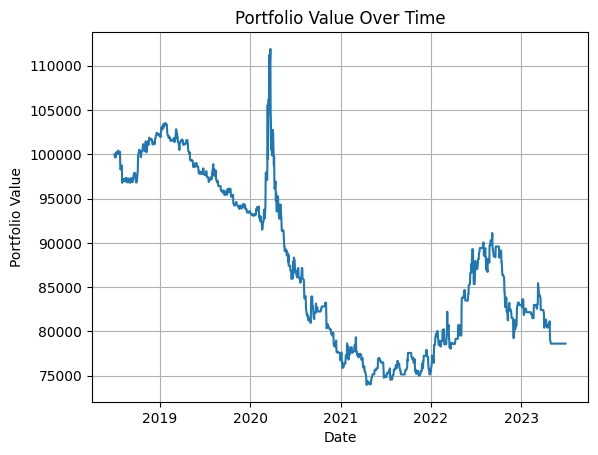

In [38]:
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime

# Calculate daily returns from price data
daily_returns = transaction_data['Close'].pct_change()

# Initialize the portfolio value and cash. We'll start with an initial cash of, say, $100,000.
cash = 100000.0

portfolio_value = []
portfolio_dates = []

# Loop only over trading days present in daily_returns.index
for date in daily_returns.index:
    if date in datewise_weightings:
        # Calculate the value based on weightings and daily returns for that date
        daily_portfolio_return = sum(datewise_weightings[date].get(ticker, 0) * (daily_returns.loc[date, ticker] if not np.isnan(daily_returns.loc[date, ticker]) else 0) for ticker in datewise_weightings[date] if ticker in daily_returns.columns)
        cash *= (1 + daily_portfolio_return)
    # Append to portfolio_value and portfolio_dates
    portfolio_value.append(cash)
    portfolio_dates.append(date)

# Convert portfolio_value list into a pandas series using portfolio_dates for the index
portfolio_value_series = pd.Series(portfolio_value, index=portfolio_dates)

# Plotting the portfolio value
plt.plot(portfolio_value_series)
plt.title("Portfolio Value Over Time")
plt.xlabel("Date")
plt.ylabel("Portfolio Value")
plt.grid(True)
plt.show()


C:\Users\Blake\AppData\Local\Temp\ipykernel_37368\3025816888.py:7: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Call ffill before calling pct_change to retain current behavior and silence this warning.
  daily_returns = transaction_data['Close'].pct_change()


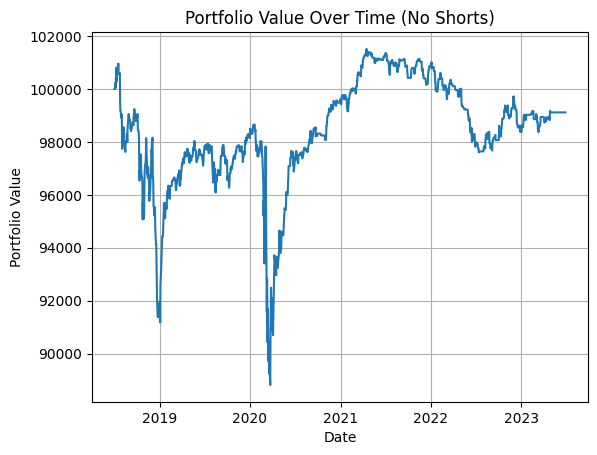

In [39]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have the datewise_weightings and transaction_data already from previous code

# Calculate daily returns from price data
daily_returns = transaction_data['Close'].pct_change()

# Initialize the portfolio value and cash. We'll start with an initial cash of, say, $100,000.
cash = 100000.0

portfolio_value = []
portfolio_dates = []

# Loop only over trading days present in daily_returns.index
for date in daily_returns.index:
    if date in datewise_weightings:
        # Calculate the value based on weightings and daily returns for that date
        
        # Prevent shorts by setting negative weightings to zero
        adjusted_weightings = {ticker: max(0, weight) for ticker, weight in datewise_weightings[date].items()}
        
        daily_portfolio_return = sum(adjusted_weightings.get(ticker, 0) * (daily_returns.loc[date, ticker] if not np.isnan(daily_returns.loc[date, ticker]) else 0) for ticker in adjusted_weightings if ticker in daily_returns.columns)
        
        cash *= (1 + daily_portfolio_return)
        
    # Append to portfolio_value and portfolio_dates
    portfolio_value.append(cash)
    portfolio_dates.append(date)

# Convert portfolio_value list into a pandas series using portfolio_dates for the index
portfolio_value_series = pd.Series(portfolio_value, index=portfolio_dates)

# Plotting the portfolio value
plt.plot(portfolio_value_series)
plt.title("Portfolio Value Over Time (No Shorts)")
plt.xlabel("Date")
plt.ylabel("Portfolio Value")
plt.grid(True)
plt.show()


[*********************100%%**********************]  1 of 1 completed


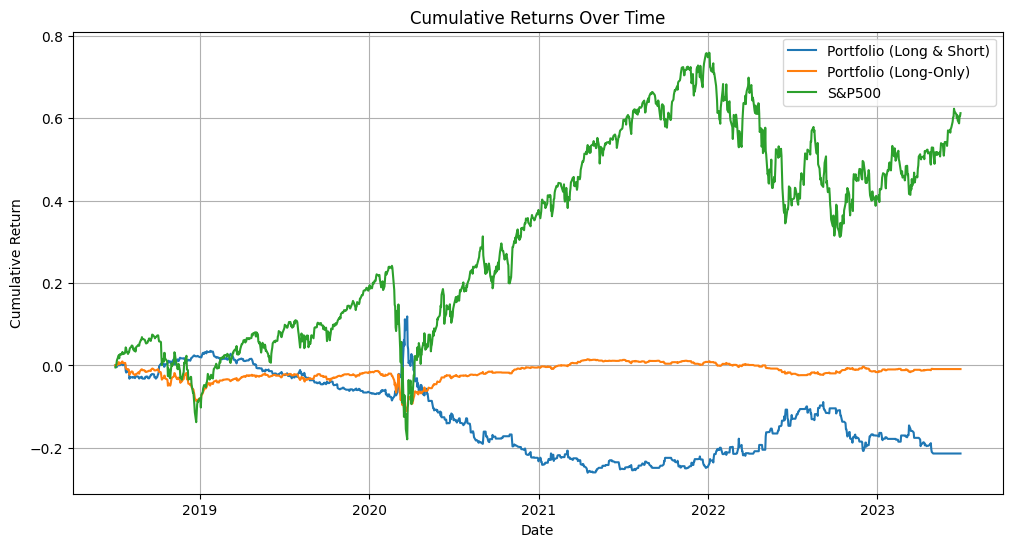

In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime

# Using your logic for Portfolio Value Over Time
daily_returns_long_short = []
cash = 100000.0
for date in daily_returns.index:
    if date in datewise_weightings:
        daily_portfolio_return = sum(datewise_weightings[date].get(ticker, 0) * (daily_returns.loc[date, ticker] if not np.isnan(daily_returns.loc[date, ticker]) else 0) for ticker in datewise_weightings[date] if ticker in daily_returns.columns)
        cash *= (1 + daily_portfolio_return)
        daily_returns_long_short.append(daily_portfolio_return)
    else:
        daily_returns_long_short.append(0)

# Using your logic for Portfolio Value Over Time (No Shorts)
daily_returns_long_only = []
cash = 100000.0
for date in daily_returns.index:
    if date in datewise_weightings:
        adjusted_weightings = {ticker: max(0, weight) for ticker, weight in datewise_weightings[date].items()}
        daily_portfolio_return = sum(adjusted_weightings.get(ticker, 0) * (daily_returns.loc[date, ticker] if not np.isnan(daily_returns.loc[date, ticker]) else 0) for ticker in adjusted_weightings if ticker in daily_returns.columns)
        cash *= (1 + daily_portfolio_return)
        daily_returns_long_only.append(daily_portfolio_return)
    else:
        daily_returns_long_only.append(0)

def calculate_cumulative_return(daily_returns):
    return (1 + daily_returns).cumprod() - 1

# Convert lists to pandas Series with appropriate datetime index
daily_returns_long_short_series = pd.Series(daily_returns_long_short, index=daily_returns.index)
daily_returns_long_only_series = pd.Series(daily_returns_long_only, index=daily_returns.index)

cumulative_returns_long_short = calculate_cumulative_return(daily_returns_long_short_series)
cumulative_returns_long_only = calculate_cumulative_return(daily_returns_long_only_series)

start = datetime(2018, 7, 1)
end = datetime(2023, 6, 30)
sp500 = yf.download('^GSPC', start=start, end=end)
sp500_returns = sp500['Close'].pct_change().dropna()
sp500_cumulative_returns = calculate_cumulative_return(sp500_returns)

plt.figure(figsize=(12,6))
plt.plot(cumulative_returns_long_short.loc[start:end], label="Portfolio (Long & Short)")
plt.plot(cumulative_returns_long_only.loc[start:end], label="Portfolio (Long-Only)")
plt.plot(sp500_cumulative_returns.loc[start:end], label="S&P500")
plt.legend()
plt.title('Cumulative Returns Over Time')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.grid(True)
plt.show()


# References
112th Congress. (2012). Public Law 112-105 Stock Act. 

Kelly, K., Playford, A., & Parlapiano, A. (2022, September 13). Stock Trades Reported by Nearly a Fifth of Congress Show Possible Conflicts. Retrieved from The New York Times: https://www.nytimes.com/interactive/2022/09/13/us/politics/congress-stock-trading-investigation.html

Quiver Quantitative . (2023, October). Senate Trading. Retrieved from Quiver Quantitative : https://www.quiverquant.com/sources/senatetrading

Ridge, J. (2022, October 20). Study: Stock Purchases by Senators Generate Abnormal Returns for Firms. Retrieved from University of Arkansas: https://news.uark.edu/articles/62333/study-stock-purchases-by-senators-generate-abnormal-returns-for-firms

